In [22]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from matplotlib.legend import _get_legend_handles_labels
from IPython.display import display, clear_output, Math
from sympy import *
from sympy.utilities.lambdify import lambdify
from tqdm import tqdm
from time import sleep
from ipywidgets.widgets import interact, FloatSlider
from scipy.stats import truncnorm

In [23]:
def get_var_dist(mean, sd, maxdev):
    minval = mean-maxdev
    maxval = mean+maxdev
    slider = FloatSlider(min=minval, max=maxval, step=(maxval-minval)/20, value=mean)
    dist = truncnorm(-maxdev/sd, maxdev/sd, loc=mean, scale=sd)
    return slider, dist

# Infectivity Function

In [24]:
infectivity_latex = r"$\frac{a}{s\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-m}{s}\right)^{2}}\left(1+\operatorname{erf}\left(\frac{k\left(\frac{x-m}{s}\right)}{\sqrt{2}}\right)\right)$"
display(Math(infectivity_latex))

a, s, m, k, x = symbols("a, s, m, k, x")
infectivity_form = a/(s*(2*pi)**.5) * exp(-1/2*((x-m)/s)**2) * (1+erf((k*(x-m)/s)/(2**.5)))
infectivity_func_raw = lambdify([x, a, m, s, k], infectivity_form, modules=['numpy', {'erf': scipy.special.erf}])

infectivity_sliders = {}
infectivity_dists = {}
infectivity_sliders["a"], infectivity_dists["a"] = get_var_dist(1100, 30, 100)
infectivity_sliders["m"], infectivity_dists["m"] = get_var_dist(20, 3, 10)
infectivity_sliders["s"], infectivity_dists["s"] = get_var_dist(17.5, 0.75, 2.5)
infectivity_sliders["k"], infectivity_dists["k"] = get_var_dist(5, 0.5, 2)

<IPython.core.display.Math object>

In [25]:
@interact(variable = infectivity_sliders.keys())
def plot_dists(variable):
    plt.hist(infectivity_dists[variable].rvs(10000), bins=20)
    plt.title("Simulated Distribution of Infectivity Variables")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

interactive(children=(Dropdown(description='variable', options=('a', 'm', 's', 'k'), value='a'), Output()), _d…

In [26]:
@interact(**infectivity_sliders)
def plot_infectivity_func(**kwargs):
    x_range = np.linspace(0,100,100)
    plt.plot(x_range, infectivity_func_raw(x_range, **kwargs))
    plt.ylim(0,65)
    
    plt.title("Infectivity Function")
    plt.xlabel("Time")
    plt.ylabel("Infectivity")
    plt.grid()
    plt.show()

interactive(children=(FloatSlider(value=1100.0, description='a', max=1200.0, min=1000.0, step=10.0), FloatSlid…

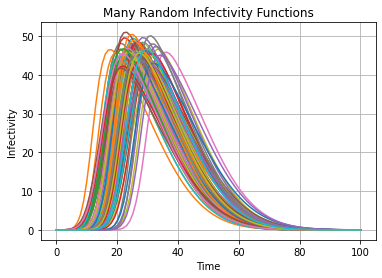

In [27]:
for i in range(100):
    a = infectivity_dists["a"].rvs()
    m = infectivity_dists["m"].rvs()
    s = infectivity_dists["s"].rvs()
    k = infectivity_dists["k"].rvs()
    
    x_range = np.linspace(0,100,100)
    plt.plot(x_range, infectivity_func_raw(x_range, a=a, m=m, s=s, k=k))

plt.title("Many Random Infectivity Functions")
plt.xlabel("Time")
plt.ylabel("Infectivity")
plt.grid()
plt.show()

# Distance Function

<IPython.core.display.Math object>

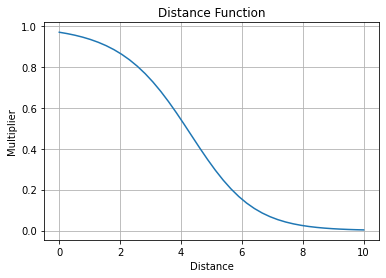

In [28]:
distance_latex = r"$1-\left(Qe^{-x}+1\right)^{-v}$"
display(Math(distance_latex))

Q, v, x = symbols('Q, v, x')
distance_prob = 1-(Q*exp(-x)+1)**(-v)
distance_params = [(Q, 100), (v, 0.75)]
distance_func = lambdify(x, distance_prob.subs(distance_params), "numpy")

x_range = np.linspace(0,10,40)
plt.plot(x_range, distance_func(x_range))
plt.title("Distance Function")
plt.xlabel("Distance")
plt.ylabel("Multiplier")
plt.grid()
plt.show()

# Exposure Function

In [29]:
exposure_latex = r"$\frac{1}{1 + e^{- k \left(x-s\right)}}$"
display(Math(exposure_latex))

k, s, x = symbols('k, s, x')
exposure_prob = 1/(1+exp(-k*(x-s)))
exposure_params = [(k, .068)]
exposure_func_raw = lambdify([x, s], exposure_prob.subs(exposure_params)-.007, "numpy")

exposure_sliders = {}
exposure_dists = {}
exposure_sliders["s"], exposure_dists["s"] = get_var_dist(100, 6, 25) #100

<IPython.core.display.Math object>

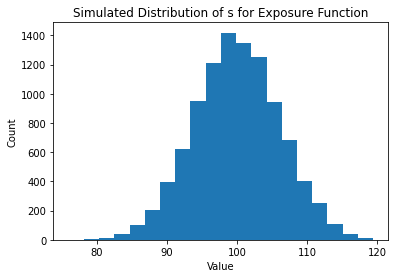

In [30]:
plt.hist(exposure_dists["s"].rvs(10000), bins=20)
plt.title("Simulated Distribution of s for Exposure Function")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [31]:
@interact(**exposure_sliders)
def plot_exposure_func(s=100):
    x_range = np.linspace(0,400,100)

    plt.plot(x_range, exposure_func_raw(x_range, s))
    plt.title("Exposure Function")
    plt.xlabel("Exposure Value")
    plt.ylabel("Probability of Catching Disease")
    plt.grid()
    plt.show()

interactive(children=(FloatSlider(value=100.0, description='s', max=125.0, min=75.0, step=2.5), Output()), _do…

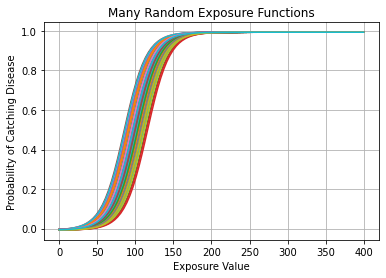

In [32]:
for i in range(100):
    s = exposure_dists["s"].rvs()
    
    x_range = np.linspace(0,400,100)
    plt.plot(x_range, exposure_func_raw(x_range, s))

plt.title("Many Random Exposure Functions")
plt.xlabel("Exposure Value")
plt.ylabel("Probability of Catching Disease")
plt.grid()
plt.show()

In [33]:
def person_wrapper(func, params):
    def inner(x, person):
        return func(x, **getattr(person, params))
    
    return inner

In [34]:
infectivity_func = person_wrapper(infectivity_func_raw, "infectivity_params")
exposure_func = person_wrapper(exposure_func_raw, "exposure_params")

# Classes

In [35]:
# https://stackoverflow.com/questions/1408818/getting-the-keyword-arguments-actually-passed-to-a-python-method
# https://stackoverflow.com/questions/8187082/how-can-you-set-class-attributes-from-variable-arguments-kwargs-in-python

class Person:
    def __init__(self, 
                 location, 
                 group, 
                 speed, 
                 exposure_decrement, 
                 infectivity_params, 
                 exposure_params):
        
        args = locals().copy()
        del args["self"]
        self.__dict__.update(args)
        
        self.angle = np.random.uniform(0, 2*np.pi)
        self.angle_deviation = .5
        
        self.exposure = 0
        self.caught_time = 0 if group=="I" else None
        self.recovered_time = None
        
    def decr_exposure(self):
        self.exposure = max(self.exposure-self.exposure_decrement, 0)
        
class Environment:
    def __init__(self, 
                 infectivity_func=infectivity_func, 
                 distance_func=distance_func, 
                 exposure_func=exposure_func, 
                 infectivity_dists=infectivity_dists,
                 exposure_dists=exposure_dists,
                 radius=8, 
                 shape=np.array([100,100]), 
                 speed=1, 
                 immunity_time=60, 
                 exposure_decrement=15, 
                 permanent_immunity=True):
        
        args = locals().copy()
        del args["self"]
        self.__dict__.update(args)
        
        self.people = {"S": [], "I": [], "R": []}
        self.time = 0
        
    def gen_location(self):
        return np.random.uniform(self.shape)
    
    def gen_params(self):
        infectivity_params = {key:dist.rvs() for key,dist in infectivity_dists.items()}
        exposure_params = {key:dist.rvs() for key,dist in exposure_dists.items()}
        return {"infectivity_params": infectivity_params, "exposure_params": exposure_params}
        
    def add_person(self, group="S"):
        person = Person(location = self.gen_location(), 
                        group = group, 
                        speed = self.speed, 
                        exposure_decrement = self.exposure_decrement,
                       **self.gen_params())
        self.people[group].append(person)
            
    def move_all(self):
        for group in self.people.values():
            for person in group:
                person.angle += np.random.uniform(-person.angle_deviation, person.angle_deviation)
                vector = person.speed*np.array([np.cos(person.angle), np.sin(person.angle)])
                person.location = np.mod(person.location+vector, self.shape)
    
    def infected_actions(self):
        idx = len(self.people["I"])-1
        while idx >= 0:
            infected = self.people["I"][idx]
            time_since_caught = self.time - infected.caught_time
            infectivity = self.infectivity_func(time_since_caught, infected)
            
            if time_since_caught>40 and infectivity<1:
                del self.people["I"][idx]
                self.people["R"].append(infected)
                infected.group = "R"
                infected.recovered_time = self.time
            else:
                for person in self.people["S"]:
                    vector = np.abs(person.location - infected.location)
                    wrapped_vector = np.minimum(vector, self.shape-vector)
                    distance = np.linalg.norm(wrapped_vector, ord=2)
                    if distance <= self.radius:
                        person.exposure += infectivity*self.distance_func(distance)
            idx -= 1
    
    def susceptible_actions(self):
        idx = len(self.people["S"])-1
        while idx >= 0:
            susceptible = self.people["S"][idx]
            if np.random.random() < self.exposure_func(susceptible.exposure, susceptible):
                del self.people["S"][idx]
                self.people["I"].append(susceptible)
                susceptible.group = "I"
                susceptible.caught_time = self.time
            else:
                susceptible.decr_exposure()
            idx -= 1
            
    def recovered_actions(self):
        if not self.permanent_immunity:
            idx = len(self.people["R"])-1
            while idx>= 0:
                recovered = self.people["R"][idx]
                if self.time > recovered.recovered_time+self.immunity_time:
                    del self.people["R"][idx]
                    self.people["S"].append(recovered)
                    recovered.group = "S"
                    recovered.exposure = 0
                idx -= 1
                
    def get_location_arrays(self):
        return [np.array([person.location for person in group]) for group in self.people.values()]
    
    def advance_time(self):
        self.time += 1
        self.move_all()
        
        self.infected_actions()
        self.susceptible_actions()
        self.recovered_actions()
    
        return self.get_location_arrays()

In [38]:
# Rerun this cell before every simulation (this generates the environment and adds the people)

np.random.seed(31415)

env = Environment(permanent_immunity=False, exposure_decrement=15)

for _ in range(199):
    env.add_person()
    
env.add_person("I")

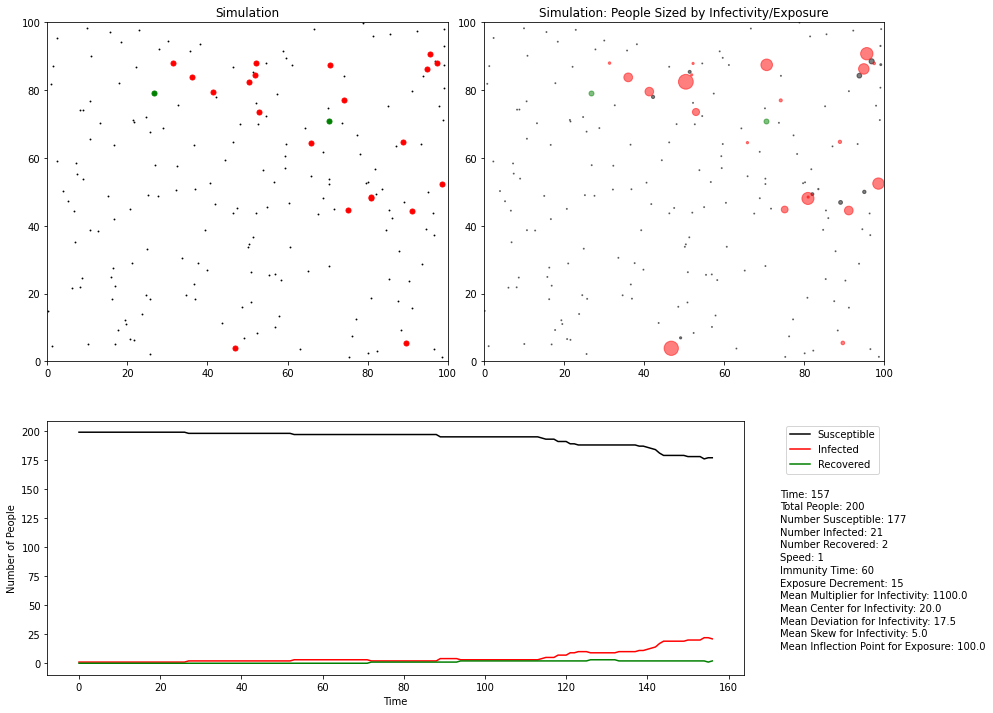

In [ ]:
# To save frames, add a folder in the same directory called output
# Otherwise, comment out the savefig line

fig = plt.figure(figsize=(15,12))
gs = GridSpec(2,4, figure=fig, height_ratios=[4,3], width_ratios=[5,2,5,2])
ax_sim1 = fig.add_subplot(gs[0,:2])
ax_sim1.set_xlim(0,env.shape[0])
ax_sim1.set_ylim(0,env.shape[1])

ax_sim2 = fig.add_subplot(gs[0,2:])
ax_sim2.set_xlim(0,env.shape[0])
ax_sim2.set_ylim(0,env.shape[1])

ax_infected = fig.add_subplot(gs[1,:-1])
ax_info = fig.add_subplot(gs[1,-1])

num_s = []
num_i = []
num_r = []

while True:
    S_locs, I_locs, R_locs = env.advance_time()
    if not S_locs.size:
        S_locs = np.empty(shape=(0,2))
    if not I_locs.size:
        I_locs = np.empty(shape=(0,2))
    if not R_locs.size:
        R_locs = np.empty(shape=(0,2))
    
    S_plot1 = ax_sim1.scatter(*S_locs.T, c="k", marker=".", s=3)
    R_plot1 = ax_sim1.scatter(*R_locs.T, c="g", marker=".", s=100)
    I_plot1 = ax_sim1.scatter(*I_locs.T, marker=".", s=100, c="r")

    ax_sim1.set_title("Simulation")
    
    I_size = np.array([env.infectivity_func(env.time - person.caught_time, person)+1 for person in env.people["I"]])
    S_size = np.array([person.exposure for person in env.people["S"]])+2
    S_plot2 = ax_sim2.scatter(*S_locs.T, c="k", marker=".", s=S_size*2, alpha=.5)
    R_plot2 = ax_sim2.scatter(*R_locs.T, c="g", marker=".", s=100, alpha=.5)
    I_plot2 = ax_sim2.scatter(*I_locs.T, marker=".", s=I_size*20, c="r", alpha=.5)
    
    ax_sim2.set_title("Simulation: People Sized by Infectivity/Exposure")
    
    num_s.append(len(env.people["S"]))
    num_i.append(len(env.people["I"]))
    num_r.append(len(env.people["R"]))
    
    ax_infected.plot(num_s, color="k", label="Susceptible")
    ax_infected.plot(num_i, color="r", label="Infected")
    ax_infected.plot(num_r, color="g", label="Recovered")
    
    ax_infected.set_xlabel("Time")
    ax_infected.set_ylabel("Number of People")
    
    ax_info.legend(*ax_infected.get_legend_handles_labels())
    ax_info.axis('off')
    ax_info.text(0,.7,"Time: "+str(env.time),size=10)
    ax_info.text(0,.65,"Total People: "+str(num_s[-1]+num_i[-1]+num_r[-1]),size=10)
    ax_info.text(0,.6,"Number Susceptible: "+str(num_s[-1]),size=10)
    ax_info.text(0,.55,"Number Infected: "+str(num_i[-1]),size=10)
    ax_info.text(0,.5,"Number Recovered: "+str(num_r[-1]),size=10)
    ax_info.text(0,.45,"Speed: "+str(env.speed),size=10)
    ax_info.text(0,.4,"Immunity Time: "+("inf" if env.permanent_immunity else str(env.immunity_time)),size=10)
    ax_info.text(0,.35,"Exposure Decrement: "+str(env.exposure_decrement),size=10)
    ax_info.text(0,.3,"Mean Multiplier for Infectivity: "+str(env.infectivity_dists["a"].mean()),size=10)
    ax_info.text(0,.25,"Mean Center for Infectivity: "+str(env.infectivity_dists["m"].mean()),size=10)
    ax_info.text(0,.2,"Mean Deviation for Infectivity: "+str(env.infectivity_dists["s"].mean()),size=10)
    ax_info.text(0,.15,"Mean Skew for Infectivity: "+str(env.infectivity_dists["k"].mean()),size=10)
    ax_info.text(0,.1,"Mean Inflection Point for Exposure: "+str(env.exposure_dists["s"].mean()),size=10)

    clear_output(wait=True)
    display(fig)
    plt.savefig("output/output"+str(env.time))
    I_plot1.remove()
    S_plot1.remove()
    R_plot1.remove()
    I_plot2.remove()
    S_plot2.remove()
    R_plot2.remove()
    ax_infected.cla()
    ax_info.cla()